# M394C Research Project Code

_by Balazs Kustar and Rutvik Choudhary_

---

## Globals

These variables set the type of algebra we are using. 

`TROP_ADD_MODE` selects whether the tropical addition operation is classical min or classical max. 

`TROP_MULT_MODE` selects whether the tropical multiplication operation is classical addition or classical multiplication. 

The valid algebras we study are $(\text{min}, +)$, $(\text{max}, +)$, $(\text{max}, \times)$. While $(\text{min}, \times)$ is technically a possible combination, we really don't care about that one for now...

In [421]:
# sets classical operation for tropical addition
# 0 : min
# 1 : max
TROP_ADD_MODE = 1

# sets classical operation for tropical multiplication
# also equal to the multiplicative identity
# 0 : plus
# 1 : times
TROP_MULT_MODE = 0

---

## Common Tropical Functions

---

**Important note:** We use arrays to represent both row vectors and column vectors. We don't care about the distinction between the two. So if you want to pass in a vector to a function, _always use a 1-D array please!_

---

`t_add(a, b)`

Generic tropical addition. Can tropically add two matrices (entry-wise), two vectors (entry-wise), or two scalars.

---

`t_mult(a, b)`

Generic tropical multiplication. Can tropically add two matrices, a matrix and a vector, a scalar and a matrix, a scalar and a vector, or two scalars.

**Important Note:** 

If you are multiplying a scalar and a matrix or a scalar and a vector, _the scalar must come first!!!_

If you are multiplying a matrix and a vector, _the matrix must come first!!!_

---

`t_scalar_mult(a, b)`

Computes the tropical multiplication of 2 scalars.

---

`t_matr_vec_mult(a, b)`

Computes the tropical multiplication of a $m \times n$ matrix and a $n$-dimensional vector.

**Important note:**

`a` _must_ be the matrix and `b` _must_ be the vector!!!

---

`t_matr_matr_mult(a, b)`

Computes the tropical multiplication of a $m \times n$ matrix and a $n \times s$ matrix.

---

`t_dot(a, b)`

Computes the tropical dot product of two vectors.

---

`t_exp(a, b)`

Computes `a` to the power of `b`, i.e. $$ \underbrace{a \bigotimes a \bigotimes ... \bigotimes a}_{b \text{ times}}$$

---

`t_eigval(matrix)`

Returns the eigenvalues of a tropical matrix.

---

`normalize(vector)`

Normalize a tropical vector.
Scalar multiplies so that the first term is the multiplicative identity.

---

`basis(vectors)`

Given a list of vectors, it removes duplicates, i.e. vectors which are simply tropical scalar multiples of another vector in the set.

---

`t_eigvec(matrix)`

Returns the unique eigenvectors of a tropical matrix. I.e., if one eigenvector is a tropical scalar multiple of another, it removes the duplicate.


In [431]:
import numpy as np
import math


# General tropical addition
# scalar - scalar
# n-vector - n-vector
# nm-matrix - nm-matrix
def t_add(a, b):
    return np.minimum(a, b) if TROP_ADD_MODE == 0 else np.maximum(a, b)


# Tropical mulitplication of two scalars
def t_scalar_mult(a, b):
    assert np.isscalar(a)
    assert np.isscalar(b)
    return a + b if TROP_MULT_MODE == 0 else a * b


# Tropical dot product
# n-vector - n-vector
def t_dot(a, b):
    a = a.flatten()
    b = b.flatten()
    assert (len(a)==len(b))
    
    terms = np.vectorize(t_scalar_mult)(a, b)
    return np.min(terms) if TROP_ADD_MODE == 0 else np.max(terms)


# Tropical multiplicaion of a matrix and a vector
# mn-vector - n-vector
def t_matr_vec_mult(a, b):
    b.flatten()
    m = np.shape(a)[0]
    n = np.shape(a)[1]
    r = len(b)
    assert (n==r)
    
    out = np.zeros(m)
    assert n == r
    for i in range(m):
        out[i] = t_dot(a[i], b)
    return out


# Tropical multiplicaion of two matrices
# mn-matrix - ns-matrix
def t_matr_matr_mult(a, b):
    m = np.shape(a)[0]
    n = np.shape(a)[1]
    r = np.shape(b)[0]
    s = np.shape(b)[1]
    assert (n==r)
    
    c = np.zeros(shape=(m, s))
    for i in range(m):
        for j in range(s):
            c[i][j] = t_dot(a[i], b[:, j])
    return c


# General tropical multiplication
# scalar - scalar
# scalar - vector
# scalar - matrix
# mn-matrix - ns-matrix
# mn-matrix - n-vector
def t_mult(a, b):
    if np.isscalar(a):
        if np.isscalar(b):
            return t_scalar_mult(a, b)
        else:
            return np.vectorize(t_scalar_mult)(a, b)

    if len(np.shape(a)) == 2:
        if len(np.shape(b)) == 2:
            return t_matr_matr_mult(a, b)
        elif len(np.shape(b)) == 1:
            return t_matr_vec_mult(a, b)
        
    # Invalid input
    assert 0


# Tropical exponentiation
def t_exp(a, b):
    return a * b if TROP_MULT_MODE == 0 else a ** b


# Calculate tropical eigenvalue of a square matrix
# TODO: ensure this works with mode2==1
def t_eigval(matrix):
    # ensure matrix is square
    n, m = np.shape(matrix)
    assert n == m
    
    ma = matrix # will store current exponent of matrix
    cur = matrix # will store current sum of matrix powers
    
    for i in range(1,n): # 1 to n-1, since the first power is already stored
        
        # compute matrix^(i+1)
        # this is the (i+1)-length optimal path matrix
        ma = t_mult(ma, matrix)
        
        # divide by path length, and combine with previous matrices
        # in max-times, this should be neg-exponentiation, not division
        cur = t_add(cur, t_exp((1/(i+1)), ma))
        
    # cur now stores the (1...n)-length optimal average-weight paths
    # find optimal value on diagonal (optimal cycle)
    val = cur[0][0]
    for i in range(n):
        val = t_add(val, cur[i][i])
        
    # optimal average-weight cycle weight is equal to tropical eigenvalue
    return val


# Normalize a tropical vector
# Ensure that the first term is the multiplicative identity
def normalize(v):
    if (len(np.shape(v))==2): # column vector
        return np.real(t_mult(t_exp(v[0][0],-1), v))
    
    else: # row vector
        return np.real(t_mult(t_exp(v[0],-1), v))

    
# Calculate basis of given list of vectors
# TODO: ensure linear combination vectors are also removed
def basis(vectors):
    count = 1
    out = []
    
    # if input is empty, return empty list
    n = len(vectors)
    if (n==0):
        return out
    
    # add the first vector, normalized
    out.append(normalize(vectors[0]))
    
    for i in range(1,n): # iterate over the rest
        vectors[i] = normalize(vectors[i])
        matches = 0
        
        # see if it matches any already in the basis
        for j in range(0,len(out)):
            if ((out[j] == vectors[i]).all()):
                matches = 1
                
        # if no matches, append to output
        if (matches == 0):
            out.append(vectors[i])
            
    return out


# Calculate tropical eigenvectors of a square matrix
# TODO: ensure this works with mode2==1
def t_eigvec(matrix):
    n, m = np.shape(matrix)
    assert n == m

    # subtract/divide out the eigenvalue
    eigval = t_eigval(matrix)
    matrix = t_mult(t_exp(eigval,-1), matrix)
    # eigval(matrix) is now the identity

    # compute "C^+" matrix (optimal paths)
    
    ma = matrix # will store exponents of matrix
    cur = matrix # will build C^+
    for i in range(1,n): # 1 to n-1, since the first power is already stored
        ma = t_mult(ma, matrix)
        cur = t_add(cur, ma)
    
    # find columns where the diagonal entry is the identity
    out = []
    cur = cur.transpose()
    for i in range(n):
        # not equality due to floating point errors
        if (math.isclose(cur[i][i], TROP_MULT_MODE, rel_tol=1e-05, abs_tol=1e-08)):
            out.append(cur[i])
            
    # compute a normalized basis
    return basis(out)


# Return tropical eigenvalue and eigenvectors
def t_eig(matrix):
    return t_eigval(matrix), t_eigvec(matrix)


# Return the tropical line segment between two points
# Output: array of pairs of points, and array of midpoints
# Note: untested on mult_mode = 1
def t_line(v1, v2):
    # reduce to 3 combinatorial types
    if(v2[1] < v1[1]):
        v1, v2 = v2, v1
        
    midpoints = []
        
    # handle trivial cases
    if(v1[1] == v2[1] or
       v1[2] == v2[2] or
       (v2[1]-v1[1]) == (v2[2]-v2[1])):
        pair = [ [v1[1],v1[2]],[v2[1],v2[2]] ]
        return [pair], midpoints
    
    out = []
    if(TROP_ADD_MODE==0): # min
        if(v2[2] > v1[2]):
            if(v2[2]-v1[2] < v2[1] - v1[1]): # v2 is below diagonal from v1
                midpoint = [v1[1]+v2[2]-v1[2], v2[2]]
            else:
                midpoint = [v2[1], v1[2]+v2[1]-v1[1]]
        else:
            midpoint = [v1[1], v2[2]]
            
        out.append([ [v1[1],v1[2]], midpoint ])
        out.append([ midpoint, [v2[1],v2[2]] ])
        midpoints.append(midpoint)
        
        return out, midpoints
    else: # max
        if(v2[2] > v1[2]):
            if(v2[2]-v1[2] < v2[1] - v1[1]): # v2 is below diagonal from v1
                midpoint = [v2[1]-(v2[2]-v1[2]),v1[2]]
            else:
                midpoint = [v1[1],v2[2]-(v2[1]-v1[1])]
        else:
            midpoint = [v2[1], v1[2]]
        
        out.append([ [v1[1],v1[2]], midpoint ])
        out.append([ midpoint, [v2[1],v2[2]] ])
        midpoints.append(midpoint)
        
        return out, midpoints

    
# Return the lines defining the tropical span of points
# Output: array of paints of points
# Note: untested on mult_mode = 1
def t_span(points):
    num = len(points)
    if(num < 2):
        return []
    
    out = []
    
    for i in range(num):
        for j in range(i+1, num):
            lines, midpoints = t_line(points[i], points[j])
            out += lines
    
    return out


# Determine whether the tropical span of some points contains a vector v
def t_span_check(points, v, debug=false):
    global TROP_ADD_MODE
    
    if(len(points) == 1):
        return np.allclose(normalize(points[0]),normalize(v))
    
    A = points.T
    B = -1*A.T

    TROP_ADD_MODE ^= 1
    span_sol = t_mult(B, v)
    TROP_ADD_MODE ^= 1
    
    check = t_mult(A, span_sol)
    
    if(debug):
        print(points)
        print(v)
        print(span_sol)
        print(check)
        print(normalize(check)-normalize(v))

    return np.allclose(normalize(check),normalize(v))
    
    

## Sample Calculations of Tropical Eigenvalues/Eigenvectors

In [409]:
# TODO

---

## Functions for Calculating the Perron-Forbenius Eigenvalue/Eigenvector

The following code uses the method described on page 7 of [Methods and Applications of (max,+) Linear Algebra](https://hal.inria.fr/inria-00073603/document):

In [367]:
from sympy import *
from scipy.linalg import eig
import matplotlib.pyplot as plt


# Compute transfer matrix
def transfer_matrix(A, h):
    n, m = np.shape(A)
    assert n == m
    out = np.zeros(shape=(n,m))

    for i in range(n):
        for j in range(m):
            out[i][j] = np.exp(A[i][j] * (1/h))
    return out


# Compute transfer PF eval/evecs in max-+
def transfer_ev(A, h):
    n,m = np.shape(A)
    E = np.exp(h*A)
    val, vec = eig(E)
    
    vec = vec.T
    val = np.abs(np.real(val))
    ind = np.argmax(val)
        
    ove = vec[ind]
    if (ove[0] < 0):
        ove = -ove
    
    for i in range(len(ove)):
        ove[i] = (1/h) * np.log(ove[i])
    ova = val[ind]
    ova = (1/h) * np.log(ova)
    return ova, normalize(ove)

# Approximate the limit of the PF-eigenvalue and eigenvector
def pf_eig(A):
    n,m = np.shape(A)
    return transfer_ev(A, 30)

In [368]:
def plotPF(matrix, n=500, div=10):
    global TROP_ADD_MODE
    store = TROP_ADD_MODE
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', adjustable='box')

    # compute tropical max+ eigenvectors
    TROP_ADD_MODE = 1
    tval, tvec = t_eig(matrix)
    for i in range(len(tvec)):
        ax.plot(tvec[i][1], tvec[i][2], 'o', color='black')
    xmin, xmax = ax.get_xlim()
    rad = (xmax-xmin)*0.02
    for i in range(len(tvec)):
        circle = plt.Circle((tvec[i][1], tvec[i][2]), rad, color='r', fill=False)
        ax.add_artist(circle)
        
    # plot tropical hyperplanes
    lines = t_span(tvec)
    for i in range(len(lines)):
        v1,v2 = lines[i]
        xcoords = [v1[0], v2[0]]
        ycoords = [v1[1], v2[1]]
        ax.plot(xcoords, ycoords,'k-')
        
    # fill tropical eigenspace
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, 100)
    Y = np.linspace(ymin, ymax, 100)
    pts = []
    for i in range(len(X)):
        for j in range(len(Y)):
            if(t_span_check(np.array(tvec),np.array([0,X[i],Y[j]]))):
                pts.append([X[i],Y[j]])
                
    pts = np.array(pts)
    if(len(pts)>0):
        ax.plot(pts[:,0],pts[:,1], "o", color='black', markersize=1, zorder=0)
        
    # plot p-f points
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        val, vec = transfer_ev(matrix, (i+1)/div)
        x[i] = vec[1]
        y[i] = vec[2]
    color = list(reversed(range(n)))
    ax.scatter(x, y, c=color, zorder=10)
    
    TROP_ADD_MODE = store
    plt.show()

## Sample Calculation of the Perron-Frobenius Eigenvector

In [413]:
a = np.array([ 0 , -2.5 , -0.5])
b = np.array([ -1 , 0 , -1.5])
c = np.array([ -1 , -1 , 0])
m1 = np.array([a, b, c])

a = np.array([ 0 , -3 , -4])
b = np.array([ -2 , 0 , -4])
c = np.array([ -2 , -3 , 0])
m2 = np.array([a, b, c])

a = np.array([ 0 , -1 , -1])
b = np.array([ -4 , 0 , -1])
c = np.array([ -1 , -1 , -4])
m3 = np.array([a, b, c])

a = np.array([ 0 , 0 , 0])
b = np.array([ 0 , 1 , -3])
c = np.array([ 0 , -2 , 1])
m4 = np.array([a, b, c])

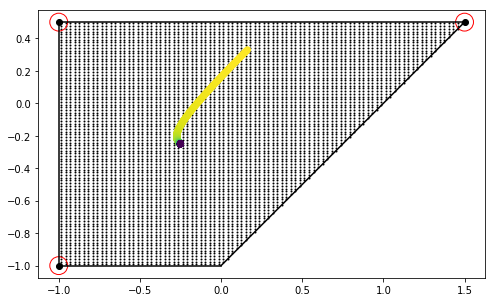

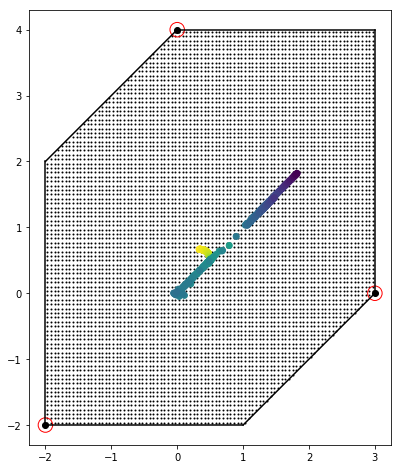

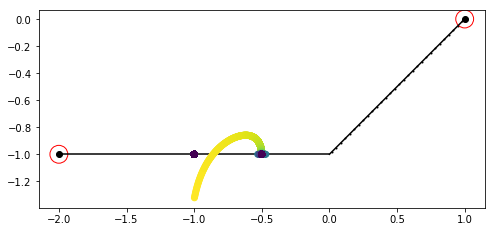

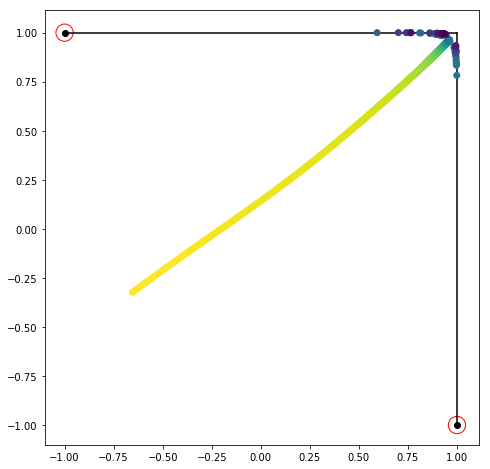

In [414]:
import warnings
warnings.filterwarnings('ignore') #'default' to revert

plotPF(m1, 4000, 100)
plotPF(m2, 3000, 100)
plotPF(m3, 3000, 100)
plotPF(m4, 3000, 100)

# Randomly Generating Test Matrices

In [438]:
store = TROP_ADD_MODE
TROP_ADD_MODE = 1

count = [0,0,0]
errors = []

for i in range(1000):
    matrix = np.round((18*np.random.rand(3,3))-9,decimals=0)
    tval, tvec = t_eig(matrix)
    count[len(tvec)-1] += 1
    
    val, vec = transfer_ev(matrix, 30)
    if(len(tvec)>2 and not t_span_check(np.array(tvec),vec)):
        errors.append(matrix)
    
print(count)
print(len(errors))
print(errors)

TROP_ADD_MODE = store

[904, 46, 50]
1
[array([[ 5., -6.,  3.],
       [-7.,  5.,  2.],
       [-5.,  3.,  5.]])]


4.0
[array([  0.,  -8., -11.]), array([ 0.,  0., -3.]), array([ 0., -8., -3.])]
False


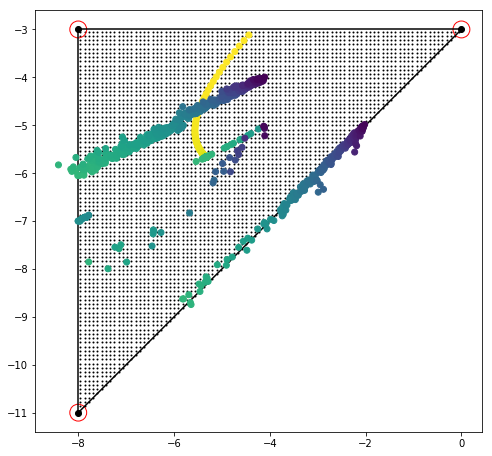

In [437]:
# Strange Example #1

matrix = np.array([[ 4., -4.,  7.],
       [-4.,  4., -6.],
       [-7.,  1.,  4.]])
tval, tvec = t_eig(matrix)
print(tval)
print(tvec)
val, vec = transfer_ev(matrix, 40)
print(t_span_check(np.array(tvec),vec))
plotPF(matrix, 3000, 100)

5.0
[array([  0., -12., -10.]), array([0., 4., 2.]), array([ 0., -1.,  2.])]
[  0. -inf  nan]
False


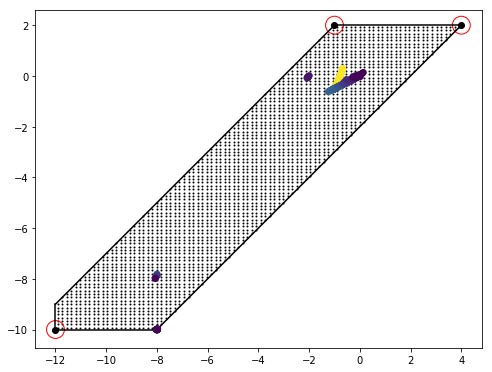

In [443]:
# Strange Example #2

matrix = np.array([[ 5., -6.,  3.],
       [-7.,  5.,  2.],
       [-5.,  3.,  5.]])
tval, tvec = t_eig(matrix)
print(tval)
print(tvec)
val, vec = transfer_ev(matrix, 30)
print(vec)
print(t_span_check(np.array(tvec),vec))
plotPF(matrix, 3000, 100)